# FIPS References

This notebook provides insights into the references of FIPS certificates.

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from sec_certs.dataset.fips import FIPSDataset
from collections import Counter
from pprint import pprint

# Typing imports
from pandas.core.frame import DataFrame, Series
from typing import Callable


#%matplotlib inline
#matplotlib.use("pgf")
sns.set_theme(style='white')
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.major.pad"] = 0
# plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams["lines.markersize"] = 4
plt.rcParams["savefig.pad_inches"] = 0.01
sns.set_palette("deep")

In [2]:
dset = FIPSDataset.from_web_latest()

In [3]:
df = dset.to_pandas()

## Analysis of FIPS references

In [4]:
refs_columns: list[str] = [
    "cert_id",
    "status",
    "standard",
    "type",
    "level",
    "embodiment",
    "module_directly_referenced_by", 
    "module_indirectly_referenced_by",
    "module_directly_referencing",
    "module_indirectly_referencing",
    "policy_directly_referenced_by",
    "policy_indirectly_referenced_by",
    "policy_directly_referencing",
    "policy_indirectly_referencing",
]

### References EDA

In [5]:
refs_df = df[refs_columns]

In [6]:
refs_direct_eda_df = refs_df[refs_df["module_directly_referencing"].notna()]
refs_indirect_eda_df = refs_df[refs_df["module_indirectly_referencing"].notna()]

In [7]:
def process_references(df: DataFrame, reference_type: str, func: Callable[[list[int]], float]) -> float | int:
    return func([len(refs) for refs in df[reference_type]])

#### Direct module references

In [8]:
direct_reference_type: str = "module_directly_referencing"
total_directly_referencing_certs: int = refs_direct_eda_df.shape[0]
total_direct_references: int = process_references(refs_direct_eda_df, direct_reference_type, sum)
maximum_direct_references: int = process_references(refs_direct_eda_df, direct_reference_type, max)
minimum_direct_references: int = process_references(refs_direct_eda_df, direct_reference_type, min)
mean_direct_references: float = round(process_references(refs_direct_eda_df, direct_reference_type, np.mean), 2)
median_direct_references: float = process_references(refs_direct_eda_df, direct_reference_type, np.median)

print(f"Total directly referencing certs: {total_directly_referencing_certs}")
print(f"Total direct references among all certs: {total_direct_references}")
print(f"Maximum directly referenced certs at once: {maximum_direct_references}")
print(f"Minimum directly referenced certs at once: {minimum_direct_references}")
print(f"Mean of all direct references: {mean_direct_references}")
print(f"Median of all direct references: {median_direct_references}")

Total directly referencing certs: 476
Total direct references among all certs: 630
Maximum directly referenced certs at once: 8
Minimum directly referenced certs at once: 1
Mean of all direct references: 1.32
Median of all direct references: 1.0


#### Indirect module references

In [9]:
indirect_reference_type: str = "module_indirectly_referencing"
total_indirectly_referencing_certs: int = refs_indirect_eda_df.shape[0]
total_indirect_references: int = process_references(refs_indirect_eda_df, indirect_reference_type, sum)
maximum_indirect_references: int = process_references(refs_indirect_eda_df, indirect_reference_type, max)
minimum_indirect_references: int = process_references(refs_indirect_eda_df, indirect_reference_type, min)
mean_indirect_references: float = round(process_references(refs_indirect_eda_df, indirect_reference_type, np.mean), 2)
median_indirect_references: float = process_references(refs_indirect_eda_df, indirect_reference_type, np.median)

print(f"Total indirectly referencing certs: {total_indirectly_referencing_certs}")
print(f"Total indirect references among all certs: {total_indirect_references}")
print(f"Maximum indirectly referenced certs at once: {maximum_indirect_references}")
print(f"Minimum indirectly referenced certs at once: {minimum_indirect_references}")
print(f"Mean of all indirect references: {mean_indirect_references}")
print(f"Median of all indirect references: {median_indirect_references}")

Total indirectly referencing certs: 476
Total indirect references among all certs: 1052
Maximum indirectly referenced certs at once: 27
Minimum indirectly referenced certs at once: 1
Mean of all indirect references: 2.21
Median of all indirect references: 1.0


#### Direct references per status

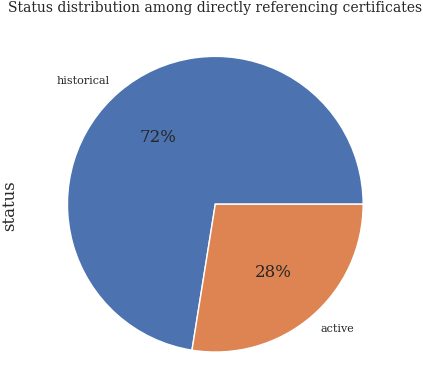

In [10]:
status_counts_df = refs_direct_eda_df["status"].value_counts().loc[lambda x: x > 0]
status_counts_df.plot.pie(autopct="%.0f%%")

plt.title("Status distribution among directly referencing certificates")
plt.show()

#### Direct references per type


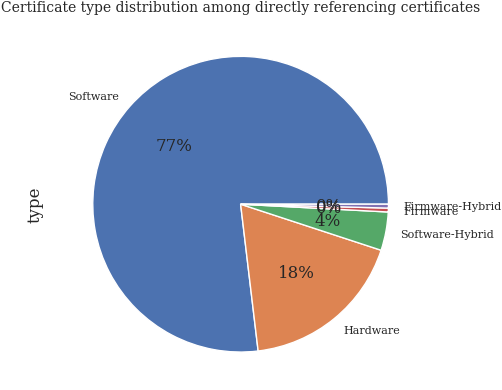

In [11]:
type_counts_df = refs_direct_eda_df["type"].value_counts().loc[lambda x: x > 0]
type_counts_df.plot.pie(autopct="%.0f%%")

plt.title("Certificate type distribution among directly referencing certificates")
plt.show()

#### Direct references per level

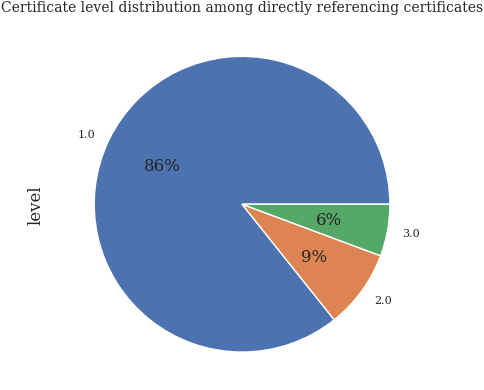

In [12]:
level_counts_df = refs_direct_eda_df["level"].value_counts().loc[lambda x: x > 0]
level_counts_df.plot.pie(autopct="%.0f%%")

plt.title("Certificate level distribution among directly referencing certificates")
plt.show()

#### Direct references per embodiment

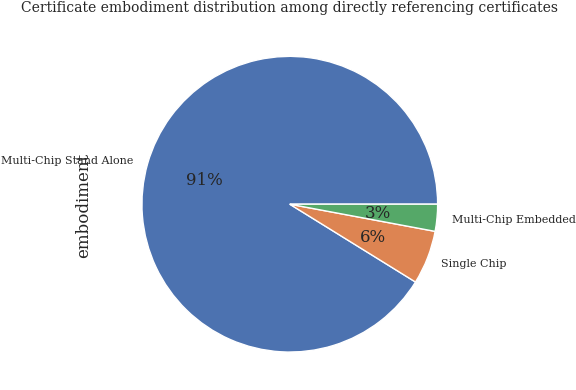

In [13]:
embodiment_counts_df = refs_direct_eda_df["embodiment"].value_counts().loc[lambda x: x > 0]
embodiment_counts_df.plot.pie(autopct="%.0f%%")

plt.title("Certificate embodiment distribution among directly referencing certificates")
plt.show()

#### Time analysis of mean of references per years

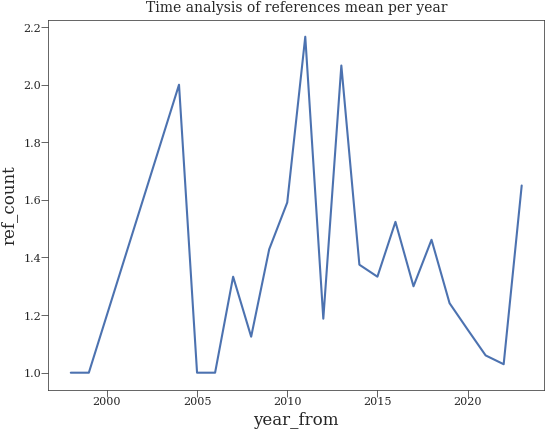

In [14]:
referencing_df = df[df["module_directly_referencing"].notna()][
    ["year_from", "module_directly_referencing"]
].copy()

referencing_df["ref_count"] = referencing_df["module_directly_referencing"].apply(len)
numeric_columns = referencing_df.select_dtypes(include=["number"])
refs_grouped_by = numeric_columns.groupby(["year_from"]).mean()
line = sns.lineplot(data=refs_grouped_by, x="year_from", y="ref_count")

plt.title("Time analysis of references mean per year")
plt.show()

#### Distribution of references of modern certificates since 2016

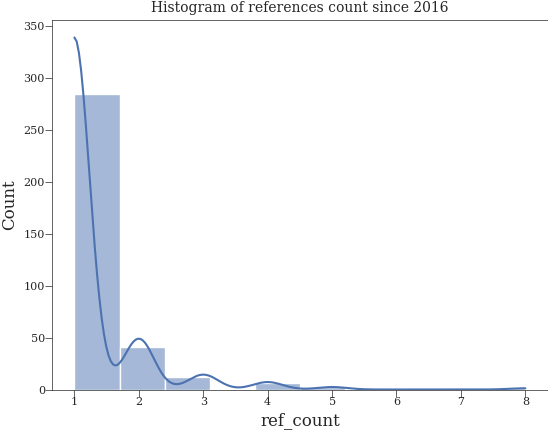

In [69]:
modern_refs = df[(df["module_directly_referencing"].notna()) & (df["year_from"] >= 2016)].copy()
modern_refs["ref_count"] = modern_refs["module_directly_referencing"].apply(len)
sns.histplot(modern_refs["ref_count"], kde=True)

plt.title("Histogram of references count since 2016")
plt.show()

#### Distribution of embodiments with assigned at least one CVE

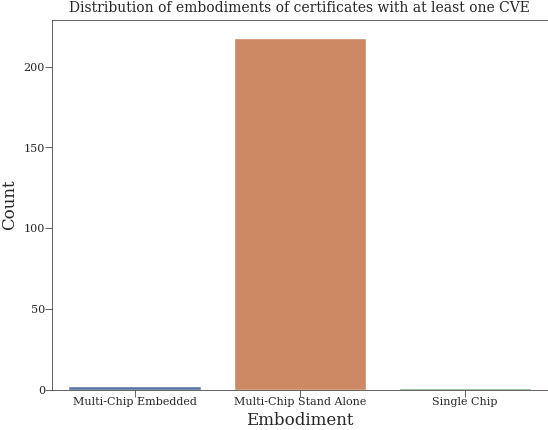

In [95]:
cve_df: DataFrame = df[df["related_cves"].notna()]

embodiments_counts = cve_df["embodiment"].value_counts()
sns.barplot(x=embodiments_counts.index, y=embodiments_counts.values)

plt.title("Distribution of embodiments of certificates with at least one CVE")
plt.xlabel("Embodiment")
plt.ylabel("Count")
plt.show()

#### Distribution of levels with assigned at least one CVE

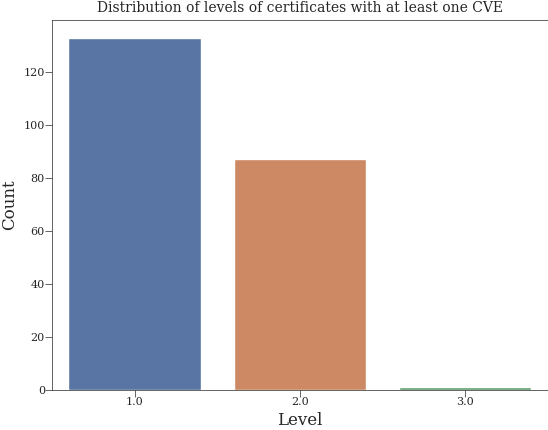

In [100]:
level_counts = cve_df["level"].value_counts()
sns.barplot(x=level_counts.index, y=level_counts.values)

plt.title("Distribution of levels of certificates with at least one CVE")
plt.xlabel("Level")
plt.ylabel("Count")
plt.show()

#### Distribution of types with assigned at least one CVE

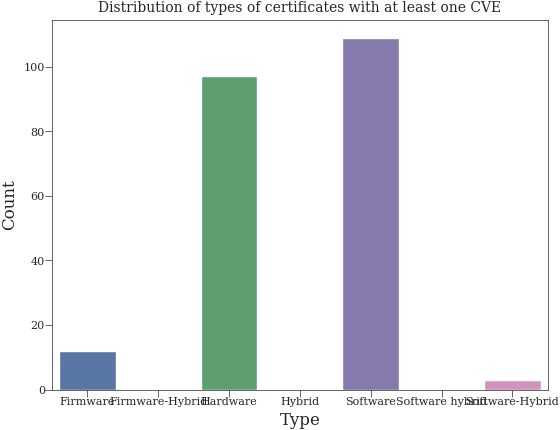

In [103]:
type_counts = cve_df["type"].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values)

plt.title("Distribution of types of certificates with at least one CVE")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

#### Distribution of statuses with assigned at least one CVE

In [18]:
level_counts = cve_df["level"].value_counts()
sns.barplot(x=level_counts.index, y=level_counts.values)

plt.title("Distribution of levels of certificates with at least one CVE")
plt.xlabel("Level")
plt.ylabel("Count")
plt.show()

Counter({'active': 33, 'historical': 188})

### Statistics how many certificates reference certificate with at least one vulnerability

In [19]:
cve_ref_df: DataFrame = df[(df["related_cves"].notna()) & (df["module_directly_referenced_by"].notna())]
total_references: int = cve_ref_df["module_directly_referenced_by"].apply(len).sum()

print(f"Total number of certificates referencing at least one certificate with at least one assigned CVE: {total_references}")

Total number of certificates referencing at least one certificate with at least one assigned CVE: 81


#### The certificate with at least one CVE assigned and maximum of references from other certs

In [20]:
maximum_references: int = cve_ref_df["module_directly_referenced_by"].apply(len).max()

print(f"Maximum amount of references from the other certificates referencing the vulnerable certificate: {maximum_references}")

Maximum amount of references from the other certificates referencing the vulnerable certificate: 7


In [21]:
cve_ref_df[cve_ref_df["module_directly_referenced_by"].apply(len) == maximum_references]

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
3c4ee858b268931a,1336,Microsoft Windows Server 2008 R2 Cryptographic...,historical,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2010-08-12,NaT,"{AES GCM#1168, ECDSA#142, Triple-DES#846, AES ...",...,"{CVE-2008-1084, CVE-2008-4269, CVE-2009-0082, ...","{2736, 1339, 1817, 1808, 1807, 1805, 1806}","{2736, 1339, 1817, 1808, 1807, 1805, 1806}",{1334},"{1333, 1334, 1321}","{1339, 1817, 1808, 1807, 1805, 1806}","{1339, 1817, 1808, 1807, 1805, 1806}",{1334},"{1333, 1334, 1321}",2010
10acb87b3040f4e1,3616,Oracle Linux 7 NSS Cryptographic Module,historical,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2020-02-19,NaT,"{RSA#C786, AES#C786, KTS#C786, HMAC#C786, DSA#...",...,"{CVE-2016-2791, CVE-2015-8385, CVE-2016-2798, ...","{3921, 4146, 4147, 4135, 3699, 4164, 3893}","{3921, 4146, 4147, 4135, 3699, 4164, 3893}",NaN,NaN,"{3893, 3921, 3699}","{3893, 3921, 3699}",NaN,NaN,2020


### Active certificates which reference at least one historical cert

In [22]:
def get_cert_property(df: DataFrame, cert_id: int, column: str) -> str | None:
    if column not in df.columns:
        raise ValueError(f"Dataset does not have column '{column}'")
    
    sub_df = df[df["cert_id"] == int(cert_id)]
    
    if not sub_df.shape[0]:  # Certificate is not in the dataset
        print(f"Cert ID: {cert_id} not in dataset")
        return None
    
    if sub_df.shape[0] > 1:  # There are more than one occurence with same ID
        print(f"Error Cert ID: {cert_id} has {sub_df.shape[0]} occurrences.")
        return None
    
    return sub_df.iloc[0][column]

In [23]:
active_certs_referencing_historical: list[int] = []
# NOTE: "cert_id" field is represented as integer, however "module_directly_referencing" is set of strings
historical_cert_ids: set[str] = set(df[df["status"] == "historical"]["cert_id"].apply(str))
active_referencing_certs: DataFrame = refs_df[(refs_df["status"] == "active") & (refs_df["module_directly_referencing"].notna())]

for _, rows in active_referencing_certs.iterrows():
    referencing_ids = rows["module_directly_referencing"]
    intersection = referencing_ids & historical_cert_ids
    
    if intersection:
        active_certs_referencing_historical.append(rows.cert_id)

hit_ratio: float = len(active_certs_referencing_historical) / len(active_referencing_certs)
print(f"Total active certificates referencing at least one historical: {len(active_certs_referencing_historical)}")
print(f"Total active certificates referencing at least one certificate: {len(active_referencing_certs)}")
print(f"Hit ratio: {round(hit_ratio, 2)}")

Total active certificates referencing at least one historical: 13
Total active certificates referencing at least one certificate: 131
Hit ratio: 0.1


#### Active certificate referencing at least one historical certificate with assigned CVE

In [24]:
active_cert_referencing_historical_with_cves: list[tuple[int, int]] = []


for _, cert in refs_df[refs_df["cert_id"].isin(active_certs_referencing_historical)].iterrows():
    cert_id = cert["cert_id"]
    
    for referenced_cert_id in cert["module_directly_referencing"]:
        referenced_cert_id_int = int(referenced_cert_id)
        related_cves = get_cert_property(df, referenced_cert_id_int, "related_cves")
        
        if not pd.isna(related_cves):
            print(f"Active certificate {cert_id} is referencing historical certificate {referenced_cert_id} with assigned CVE")
            active_cert_referencing_historical_with_cves.append((cert_id, referenced_cert_id_int))
            

active_cert_referencing_historical_with_cves

Active certificate 3939 is referencing historical certificate 3860 with assigned CVE


[(3939, 3860)]

### Certificates with higher levels referencing certficates with lower levels

In [25]:
referencing_certs: DataFrame = refs_df[refs_df["module_directly_referencing"].notna()]
cert_level_ids: dict[int, set[str]] = {}
unique_levels: list[int] = df["level"].apply(int).unique()

for level in df["level"].unique():
    level_cert_ids: set[str] = set(df[df["level"] == level]["cert_id"].apply(str))
    cert_level_ids[int(level)] = level_cert_ids

In [26]:
def get_cert_ids_referencing_lower_level_cert(level_referencing_certs_df: DataFrame, lower_cert_ids: set[str]) -> list[int]:
    cert_ids = []
    
    for _, cert in level_referencing_certs_df.iterrows():
        if cert["module_directly_referencing"] & lower_cert_ids:
            cert_ids.append(cert["cert_id"])
    
    return cert_ids            

#### Level 2 referencing at least one certificate of level 1

In [27]:
LEVEL2: int = 2 
below_level2_cert_ids: set[str] = cert_level_ids[1]
level2_ref_certs = referencing_certs[referencing_certs["level"] == LEVEL2]
level2_referencing_lower_level = get_cert_ids_referencing_lower_level_cert(level2_ref_certs, below_level2_cert_ids)
ratio: float = len(level2_referencing_lower_level) / level2_ref_certs.shape[0]

print(f"Total amount of certificates with level {LEVEL2} referencing at least one certificate: {level2_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(level2_referencing_lower_level)}")
print(f"Hit ratio: {round(ratio, 2)}")

Total amount of certificates with level 2 referencing at least one certificate: 41
Total amount of certicates with reference at least one certificate with lower level: 16
Hit ratio: 0.39


#### Level 3 referencing at least one certificate of level 1 or 2

In [28]:
LEVEL3: int = 3
below_level3_cert_ids = below_level2_cert_ids | cert_level_ids[2]
level3_ref_certs = referencing_certs[referencing_certs["level"] == LEVEL3]
level3_referencing_lower_level = get_cert_ids_referencing_lower_level_cert(level3_ref_certs, below_level3_cert_ids)
ratio: float = len(level3_referencing_lower_level) / level3_ref_certs.shape[0]

print(f"Total amount of certificates with level {LEVEL3} referencing at least one certificate: {level3_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(level3_referencing_lower_level)}")
print(f"Hit ratio: {round(ratio, 2)}")

Total amount of certificates with level 3 referencing at least one certificate: 27
Total amount of certicates with reference at least one certificate with lower level: 1
Hit ratio: 0.04


#### Level 4 referencing at least one certificate of level 1, 2 or 3

In [29]:
LEVEL4: int = 4
below_level4_cert_ids = below_level3_cert_ids | cert_level_ids[3]
level4_ref_certs = referencing_certs[referencing_certs["level"] == LEVEL4]
level4_referencing_lower_level = get_cert_ids_referencing_lower_level_cert(level4_ref_certs, below_level4_cert_ids)
print(f"Total amount of certificates with level {LEVEL4} referencing at least one certificate: {level4_ref_certs.shape[0]}")

Total amount of certificates with level 4 referencing at least one certificate: 0


### Distribution of references among embodiments

In [30]:
def get_embodiment_references(refs_df: DataFrame, embodiment: str) -> dict[str, int]:
    result: dict[str, int] = {}
    sub_df = refs_df[(refs_df["embodiment"] == embodiment) & (refs_df["module_directly_referencing"].notna())]
    
    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_embodiment: str = get_cert_property(refs_df, cert_id, "embodiment")
            result[referenced_embodiment] = result.get(referenced_embodiment, 0) + 1
    
    return result

In [31]:
final_embodiment_statistics: dict[str, dict[str, int]] = {} 

for embodiment in refs_df["embodiment"].unique():
    final_embodiment_statistics[embodiment] = get_embodiment_references(refs_df, embodiment)

pprint(final_embodiment_statistics)

{'Multi-Chip Embedded': {'Multi-Chip Embedded': 13, 'Single Chip': 2},
 'Multi-Chip Stand Alone': {'Multi-Chip Embedded': 7,
                            'Multi-Chip Stand Alone': 548,
                            'Single Chip': 29},
 'Single Chip': {'Multi-Chip Embedded': 2,
                 'Multi-Chip Stand Alone': 1,
                 'Single Chip': 28}}


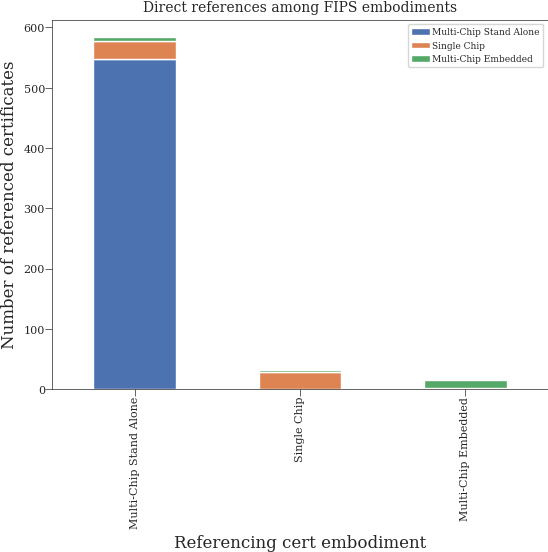

In [32]:
embodiment_df = pd.DataFrame(final_embodiment_statistics).fillna(0).astype(int).transpose()
embodiment_df.plot(kind="bar", stacked=True)

plt.xlabel("Referencing cert embodiment")
plt.ylabel("Number of referenced certificates")
plt.title("Direct references among FIPS embodiments")
plt.show()

### Distribution of references among types

In [33]:
def get_type_references(refs_df: DataFrame, cert_type: str) -> dict[str, int]:
    result = {}
    sub_df = refs_df[(refs_df["type"] == cert_type) & (refs_df["module_directly_referencing"].notna())]
    
    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_type: str = get_cert_property(refs_df, cert_id, "type")
            result[referenced_type] =result.get(referenced_type, 0) + 1

    return result

In [34]:
final_type_statistics: dict[str, dict[str, int]] = {}

for cert_type in refs_df["type"].unique():
    final_type_statistics[cert_type] = get_type_references(refs_df, cert_type)

pprint(final_type_statistics)

{'Firmware': {'Firmware': 1, 'Hardware': 1},
 'Firmware-Hybrid': {'Hardware': 2},
 'Hardware': {'Firmware': 2,
              'Firmware-Hybrid': 2,
              'Hardware': 77,
              'Software': 9},
 'Hybrid': {},
 'Software': {'Firmware': 1,
              'Hardware': 1,
              'Software': 504,
              'Software-Hybrid': 3},
 'Software hybrid': {},
 'Software-Hybrid': {'Hardware': 5, 'Software': 6, 'Software-Hybrid': 16}}


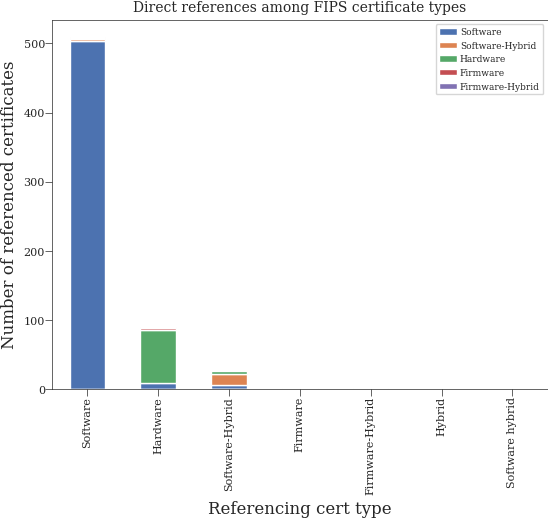

In [35]:
cert_type_df = pd.DataFrame(final_type_statistics).fillna(0).astype(int).transpose()
cert_type_df.plot(kind="bar", stacked=True)

plt.xlabel("Referencing cert type")
plt.ylabel("Number of referenced certificates")
plt.title("Direct references among FIPS certificate types")
plt.show()

### Temporal evolution of references in time

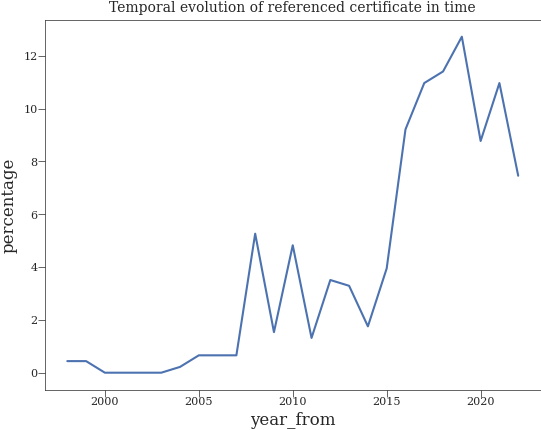

In [36]:
def convert_refences_count_to_relative(number: int, n_issued_certs: int) -> float:
    return 100 * number / n_issued_certs

refs_df: DataFrame = df[df["module_directly_referencing"].notna()]
temporal_df: DataFrame = refs_df[refs_df["year_from"] < 2023].copy()
total_referencing_certs: int = temporal_df.shape[0]
temporal_df["directly_referencing_sum"] = temporal_df["module_directly_referencing"].apply(len)
grouped_df: DataFrame = temporal_df.groupby("year_from")
converted_df: DataFrame = grouped_df.size().reset_index(name="year_references")

# Fill missing years
dataset_years: set[int] = set(converted_df["year_from"])
years_interval: set[int] = set(range(min(dataset_years), max(dataset_years) + 1))
missing_years: set[int] = years_interval - dataset_years

for year in missing_years:
    converted_df.loc[len(converted_df.index)] = (year, 0)

n_issues_certs = converted_df["year_references"].sum()
converted_df["percentage"] = converted_df["year_references"].apply(convert_refences_count_to_relative, args=(total_referencing_certs,))
line = sns.lineplot(data=converted_df, x="year_from", y="percentage")

plt.title("Temporal evolution of referenced certificate in time")
plt.show()

### Cross-references among certificates

Certificate A directly references certificate B and at the same time certificate B directly references certificate A.
In other words intersection of `module_directly_referenced_by` and `module_directly_referencing` results into discovery of cross references in the dataset.

In [37]:
result: list[tuple[int, int]] = []
cross_references_df: DataFrame = df[(df["module_directly_referenced_by"].notna()) & (df["module_directly_referencing"].notna())]


for _, cert in cross_references_df.iterrows():
    referenced_by = cert["module_directly_referenced_by"]
    referencing = cert["module_directly_referencing"]
    cert_id = cert["cert_id"]
    
    intersection: set[str] = referenced_by & referencing
    
    
    for another_cert_id in intersection:
        another_cert_id_int = int(another_cert_id)
        
        if not (another_cert_id_int, cert_id) in result:
            result.append((cert_id, int(another_cert_id)))

print(result)
# TODO - Investigate how are 3382, 3383, 3384 related

[(3383, 3382), (3382, 3384), (63, 80)]


In [38]:
df[df["cert_id"].isin([3382, 3383, 3384])]

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
efb092e03612f568,3383,River Cryptographic Module,active,FIPS 140-2,Hardware,1.0,Multi-Chip Embedded,2019-03-22,2024-03-21,"{SHS#4536, DRBG#2285, KTS#5656, ECDSA#1529, SH...",...,NaN,{3382},"{3383, 3382, 3384}",{3382},"{3383, 3382, 3384}",{3382},"{3383, 3382, 3384}",{3382},"{3383, 3382, 3384}",2019
a080dde530fce451,3382,Titan Chip,active,FIPS 140-2,Hardware,1.0,Single Chip,2019-03-22,2024-03-21,"{ECDSA#1529, SHS#4537, RSA#3045, SHS#4536}",...,NaN,"{3383, 3384}","{3383, 3382, 3384}","{3383, 3384}","{3383, 3382, 3384}","{3383, 3384}","{3383, 3382, 3384}","{3383, 3384}","{3383, 3382, 3384}",2019
6ef02a389c6415e7,3384,Delta Cryptographic Module,active,FIPS 140-2,Hardware,1.0,Multi-Chip Embedded,2019-03-27,2024-03-26,"{SHS#4536, DRBG#2285, KTS#5656, ECDSA#1529, SH...",...,NaN,{3382},"{3383, 3382, 3384}",{3382},"{3383, 3382, 3384}",{3382},"{3383, 3382, 3384}",{3382},"{3383, 3382, 3384}",2019


### Referenced certs, which are not referencing any other cert

In [39]:
not_referencing_df: DataFrame = df[(df["module_directly_referencing"].isna()) & (df["module_directly_referenced_by"].notna())]
print(f"In the dataset is total of {not_referencing_df.shape[0]} certificates which are referenced by at least one cert and not referencing any other certs.")

In the dataset is total of 151 certificates which are referenced by at least one cert and not referencing any other certs.


#### Status of the certificates

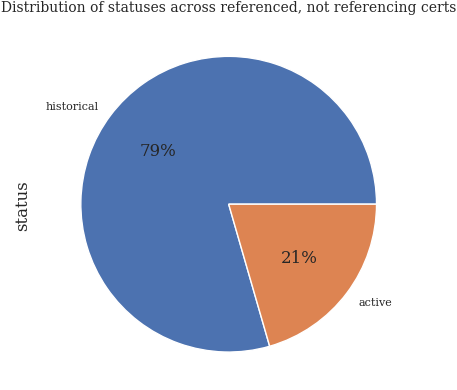

In [40]:
not_referencing_status_df: DataFrame = not_referencing_df["status"].value_counts().loc[lambda x: x > 0]
not_referencing_status_df.plot.pie(autopct="%.0f%%")

plt.title("Distribution of statuses across referenced, not referencing certs")
plt.show()

#### Histogram of CVEs

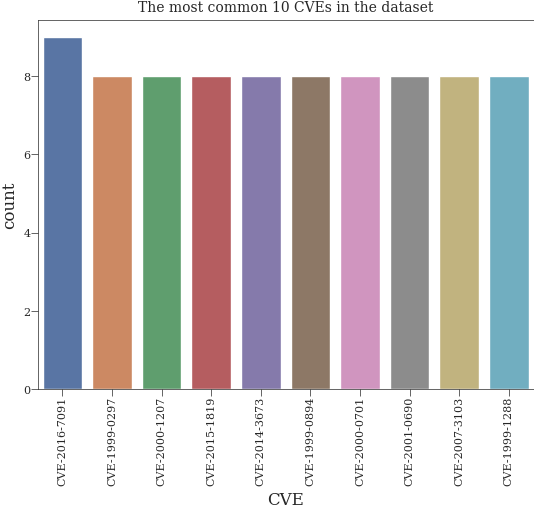

In [41]:
number_of_cves: int = 10
counter: Counter = Counter()

for cve_set in not_referencing_df["related_cves"]:
    if pd.isna(cve_set):
        continue
    counter.update(cve_set)

not_referencing_cve_df: DataFrame = pd.DataFrame.from_dict(counter, orient="index").reset_index()
not_referencing_cve_df.columns = ("CVE", "count")
not_referencing_cve_df.sort_values(by="count", ascending=False, inplace=True)
sns.barplot(x="CVE", y="count", data=not_referencing_cve_df.head(number_of_cves))

plt.title(f"The most common {number_of_cves} CVEs in the dataset")
plt.xticks(rotation=90)
plt.show()

### Certificates which are referenced, but not referencing any other certificate

In [42]:
not_referenced_df: DataFrame = df[(df["module_directly_referencing"].notna()) & (df["module_directly_referenced_by"].isna())]
print(f"There are total of {not_referenced_df.shape[0]} certs, which are referencing at least one other cert and referenced by no other cert")

There are total of 379 certs, which are referencing at least one other cert and referenced by no other cert


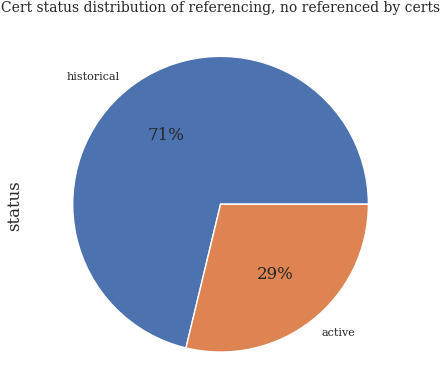

In [43]:
not_referenced_status_df: DataFrame = not_referenced_df["status"].value_counts().loc[lambda x: x > 0]
not_referenced_status_df.plot.pie(autopct="%.0f%%")
plt.title("Cert status distribution of referencing, no referenced by certs")
plt.show()

#### Histogram of CVEs

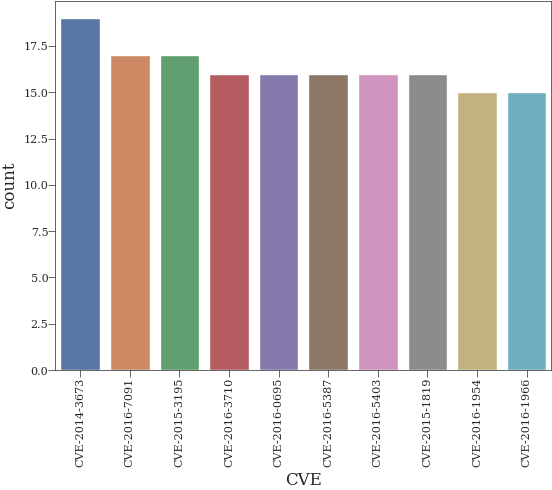

In [44]:
number_of_cves: int = 10
counter: Counter = Counter()
cve_rich_certs_df: DataFrame = not_referenced_df[not_referenced_df["related_cves"].notna()]
    
for cve_set in cve_rich_certs_df["related_cves"]:
    counter.update(cve_set)
    
not_referenced_by_df: DataFrame = pd.DataFrame.from_dict(counter, orient="index").reset_index()
not_referenced_by_df.columns = ("CVE", "count")
not_referenced_by_df.sort_values(by="count", ascending=False, inplace=True)

sns.barplot(x="CVE", y="count", data=not_referenced_by_df.head(number_of_cves))

plt.xticks(rotation=90)
plt.show()

### Certificate overview

In [45]:
CHOSEN_CERT_COLOR: str = "lightgreen"
REFERENCING_COLOR: str = "lightblue"
REFERENCED_BY_COLOR: str = "red"

In [46]:
cert_id: int = 4512  # Enter the certificate ID you are interested in

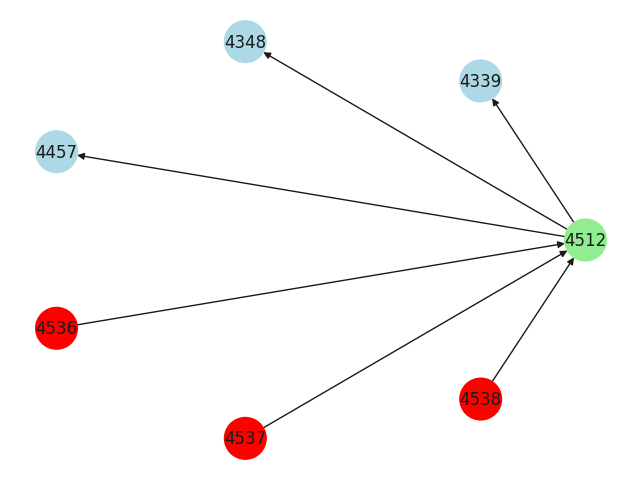

In [47]:
# TODO - Enrich graph with additional information (e.g. assigned CVEs to certificate, active/historical)
refs_df: DataFrame = df[df["module_directly_referencing"].notna()]

if not refs_df[refs_df["cert_id"] == cert_id].shape[0]:
    print("Cert ID is not in the dataset, or does not references any other certificates")
    sys.exit()

cert_id_series: Series = refs_df[refs_df["cert_id"] == cert_id].iloc[0]
cert_dgst: str = refs_df[refs_df["cert_id"] == cert_id].index[0]
color_map: list[str] = [CHOSEN_CERT_COLOR]
graph: nx.DiGraph = nx.DiGraph()
graph.add_node(cert_id)

# Display which certificates are directly referenced by the chosen certificate
for referenced_cert_id in cert_id_series["module_directly_referencing"]:
    graph.add_node(referenced_cert_id)
    graph.add_edge(cert_id, referenced_cert_id)
    color_map.append(REFERENCING_COLOR)


# Display which certificates are directly referencing the chosen certificate
for referencing_cert_id in cert_id_series["module_directly_referenced_by"]:
    graph.add_node(referencing_cert_id)
    graph.add_edge(referencing_cert_id, cert_id)
    color_map.append(REFERENCED_BY_COLOR)


pos = nx.circular_layout(graph)
nx.draw(graph, pos, arrows=True, node_color=color_map, with_labels=True, node_size=900)

In [48]:
print(f"Certificate with id {cert_id}:")
print(f" - references the certificates {cert_id_series['module_directly_referencing']}")
print(f" - is referenced by certificates {cert_id_series['module_directly_referenced_by']}")
print(f" - its page is at https://seccerts.org/fips/{cert_dgst}/")

Certificate with id 4512:
 - references the certificates {'4339', '4348', '4457'}
 - is referenced by certificates {'4536', '4537', '4538'}
 - its page is at https://seccerts.org/fips/033581b0970477af/


### Graph of the most referenced certificate

In [49]:
STATUS_TO_COLOUR_MAPPING: dict[str, str] = {
    "active": "lightblue",
    "historical": "red",
    "revoked": "blue",
}

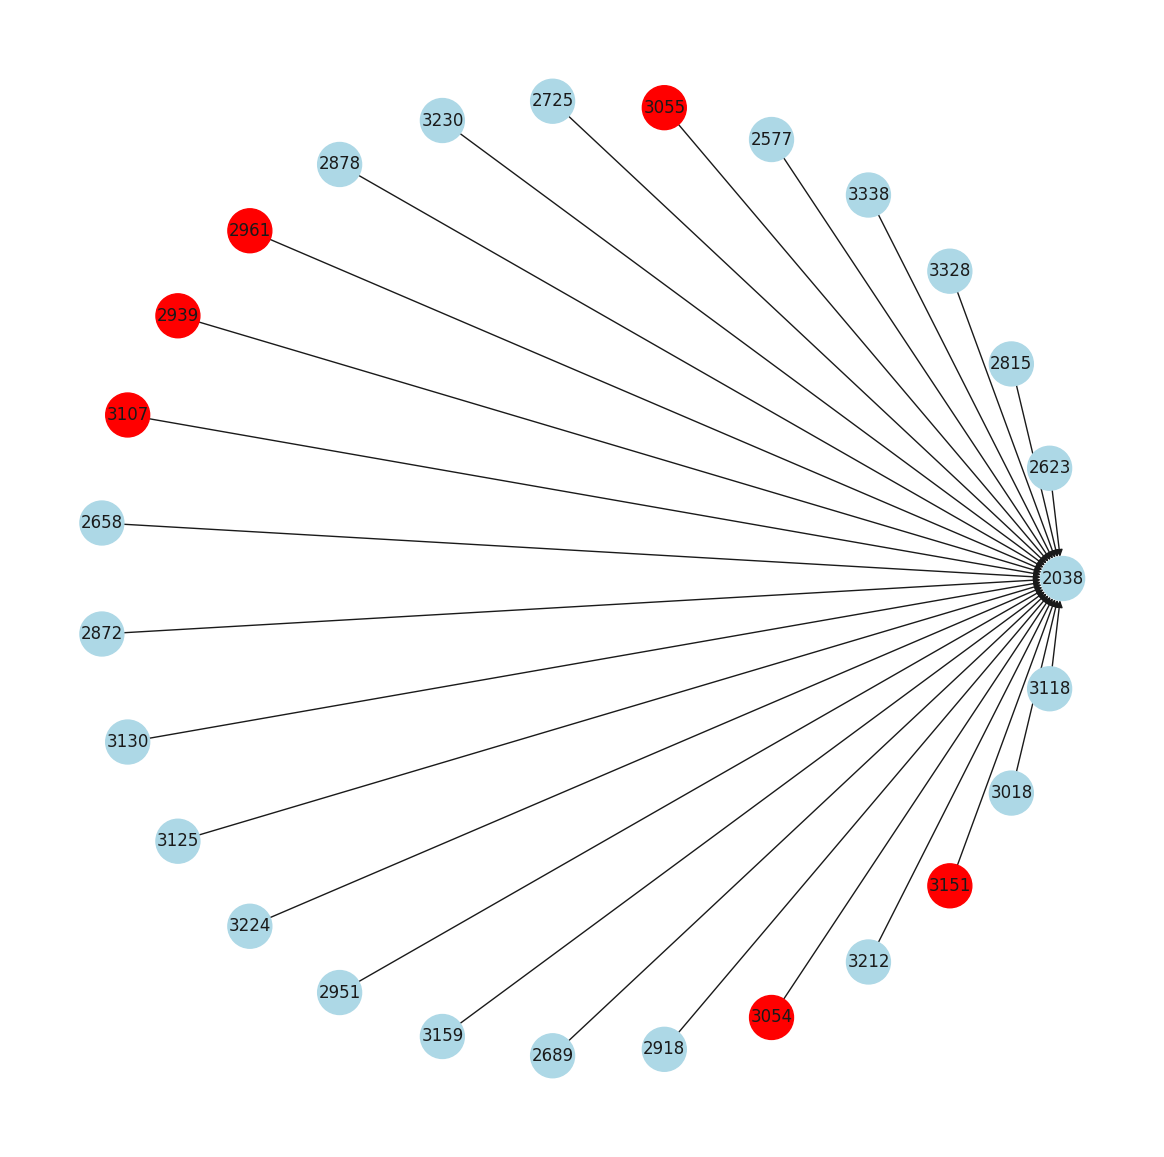

In [50]:
# TODO - Enrich the graph nodes with assigned CVEs
graph = nx.DiGraph()
node_colors: list[str] = []
referenced_by_df: DataFrame = df[df["module_directly_referenced_by"].notna()]
max_referenced_by_num: int = referenced_by_df["module_directly_referenced_by"].apply(len).max()
most_referenced_certificate: Series = referenced_by_df[referenced_by_df["module_directly_referenced_by"].apply(len) == max_referenced_by_num].iloc[0]

origin_cert_id: int = most_referenced_certificate["cert_id"]
origin_cert_status: str = most_referenced_certificate["status"]
graph.add_node(origin_cert_id)
node_colors.append(STATUS_TO_COLOUR_MAPPING[origin_cert_status])

for cert_id_str in most_referenced_certificate["module_directly_referenced_by"]:
    cert_id_int = int(cert_id_str)
    graph.add_node(cert_id_int)
    graph.add_edge(cert_id_int, origin_cert_id)
    cert_status: str = get_cert_property(df, cert_id_int, "status")
    node_colors.append(STATUS_TO_COLOUR_MAPPING[cert_status])

fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, node_color=node_colors, arrows=True, with_labels=True, node_size=1000)
plt.show()

### Graph of the most referencing certitificate

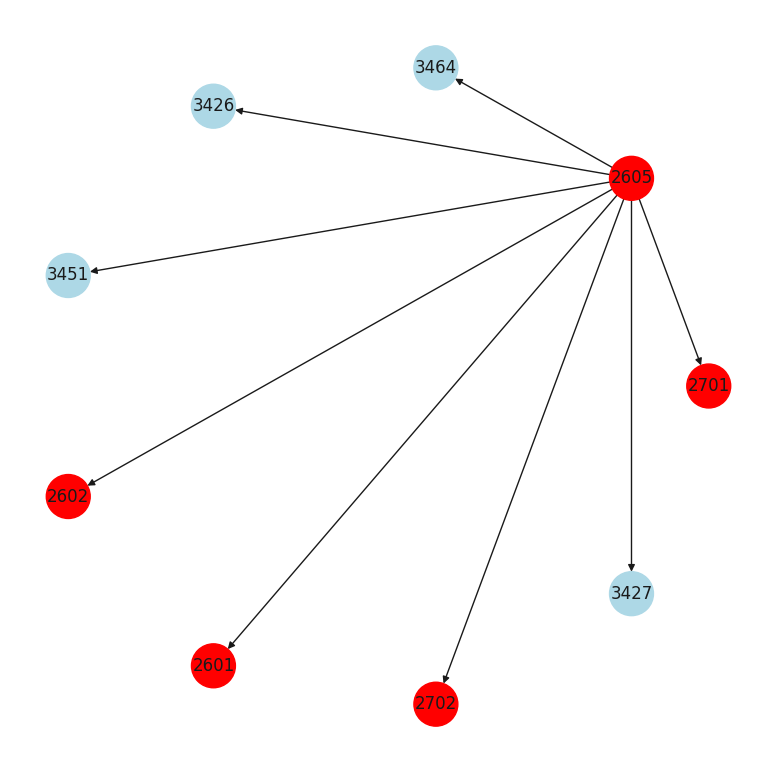

In [51]:
# TODO - Enrich the graph nodes with assigned CVEs
graph = nx.DiGraph()
node_colors: list[str] = []
referencing_df: DataFrame = df[df["module_directly_referencing"].notna()]
max_referencing_num: int = referencing_df["module_directly_referencing"].apply(len).max()
most_referencing_cert: Series = referencing_df[referencing_df["module_directly_referencing"].apply(len) == max_referencing_num].iloc[0]
origin_cert_id: int = most_referencing_cert["cert_id"]
origin_cert_status: str = most_referencing_cert["status"]
node_colors.append(STATUS_TO_COLOUR_MAPPING[origin_cert_status])


for cert_id_str in most_referencing_cert["module_directly_referencing"]:
    cert_id_int = int(cert_id_str)
    graph.add_node(cert_id_int)
    graph.add_edge(origin_cert_id, cert_id_int)
    cert_status: str = get_cert_property(df, cert_id_int, "status")
    node_colors.append(STATUS_TO_COLOUR_MAPPING[cert_status])

    
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, node_color=node_colors, arrows=True, with_labels=True, node_size=1000)
plt.show()